In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
ds_train = image_dataset_from_directory(
    '../cifar-10-stable-diffusion-detection/train',
    labels='inferred',
    label_mode='binary',
    image_size=[64,64],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 100000 files belonging to 2 classes.


In [4]:
ds_test = image_dataset_from_directory(
    '../cifar-10-stable-diffusion-detection/test',
    labels='inferred',
    label_mode='binary',
    image_size=[64,64],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 20000 files belonging to 2 classes.


In [5]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [6]:
ds_train = (
    ds_train
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


In [7]:
ds_valid = (
    ds_test
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [8]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[64, 64, 3]),
    
    # Data Augmentation
    
    preprocessing.RandomFlip(mode='horizontal'),
    

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Epoch 1/50
1563/1563 [==============================] - 42s 27ms/step - loss: 0.3342 - binary_accuracy: 0.8469 - val_loss: 0.2344 - val_binary_accuracy: 0.9026
Epoch 2/50
1563/1563 [==============================] - 41s 26ms/step - loss: 0.2130 - binary_accuracy: 0.9154 - val_loss: 0.1927 - val_binary_accuracy: 0.9212
Epoch 3/50
1563/1563 [==============================] - 41s 26ms/step - loss: 0.1912 - binary_accuracy: 0.9242 - val_loss: 0.1796 - val_binary_accuracy: 0.9288
Epoch 4/50
1563/1563 [==============================] - 43s 27ms/step - loss: 0.1776 - binary_accuracy: 0.9295 - val_loss: 0.1775 - val_binary_accuracy: 0.9297
Epoch 5/50
1563/1563 [==============================] - 47s 30ms/step - loss: 0.1674 - binary_accuracy: 0.9348 - val_loss: 0.1692 - val_binary_accuracy: 0.9321
Epoch 6/50
1563/1563 [==============================] - 50s 32ms/step - loss: 0.1622 - binary_accuracy: 0.9366 - val_loss: 0.1745 - val_binary_accuracy: 0.9308
Epoch 7/50
1563/1563 [==================

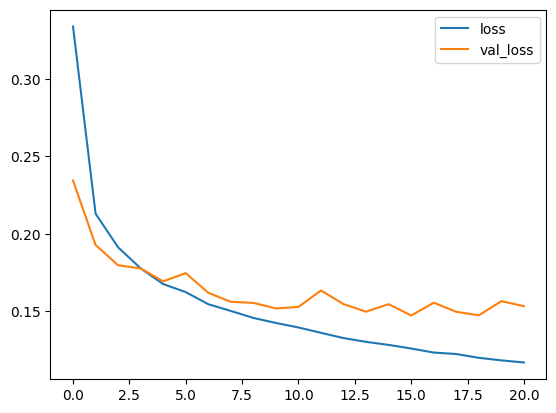

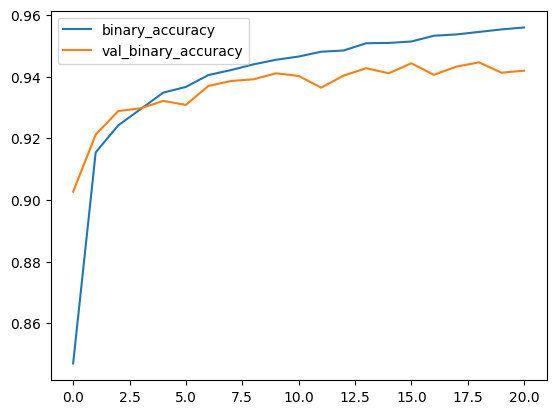

In [10]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
    callbacks=[early_stopping],
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();